# Decision Tree

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.datasets import load_iris
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

## Load and Preprocess the Dataset

In [2]:
iris = load_iris(as_frame=True)
bins_nr = 5
petal_length_binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
petal_width_binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

X = iris.data[['petal length (cm)', 'petal width (cm)']].copy()
X['petal length (cm) bins'] = petal_length_binner.fit_transform(X[['petal length (cm)']])
X['petal width (cm) bins'] = petal_width_binner.fit_transform(X[['petal width (cm)']])
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train = X_train.drop(['petal length (cm)', 'petal width (cm)'], axis=1)

## Create the Model from Scratch

In [3]:
class DecisionTreeClassifierFromScratch:
    PLOT_X1_LIM = [0, 7]
    PLOT_X2_LIM = [0, 3]
    PLOT_PREDICTIONS_LIM = [0, 3]
    COLORS = ['tab:blue', 'tab:orange', 'tab:green']
    CMAP = colors.LinearSegmentedColormap.from_list('', ['tab:blue', 'tab:orange', 'tab:green', 
                                                         'black'])

    def __init__(self):
        self.tree = {}
        self.target = None
        self.target_values = None
    
    def get_gini_index_for_feature_value(self, dataset, feature, feature_value):
        gini_index_for_feature_value = 1
        feature_value_indexes = dataset[feature] == feature_value
        feature_value_appearance_nr = len(dataset[feature_value_indexes])

        for target_value in self.target_values:
            target_value_indexes = dataset[self.target] == target_value
            matching_indexes = feature_value_indexes & target_value_indexes
            gini_index_for_feature_value -= (
                matching_indexes.sum() / feature_value_appearance_nr
            ) ** 2

        return gini_index_for_feature_value
    
    def get_gini_index_for_feature(self, dataset, dataset_length, feature):
        gini_index_for_feature = 0
        feature_values = dataset[feature].unique()

        for feature_value in feature_values:
            weight = len(dataset[dataset[feature] == feature_value]) / dataset_length
            gini_index_for_feature_value = self.get_gini_index_for_feature_value(dataset, 
                                                                                 feature, 
                                                                                 feature_value)
            gini_index_for_feature += weight * gini_index_for_feature_value

        return gini_index_for_feature

    def is_leaf_node(self, dataset):
        target_value_appearance_nrs = []
        
        for target_value in self.target_values:
            target_value_appearance_nr = len(dataset[dataset[self.target] == target_value])
            target_value_appearance_nrs.append(target_value_appearance_nr)

        is_pure_node = np.max(target_value_appearance_nrs) == len(dataset)
        is_the_only_remained_feature = len(dataset.columns) < 2
        is_leaf_node = is_pure_node or is_the_only_remained_feature
        leaf_node_prediction = self.target_values[np.argmax(target_value_appearance_nrs)]
        
        return is_leaf_node, leaf_node_prediction
        
    def split_feature_recursively(self, tree, dataset):
        dataset_length = len(dataset)
        features = list(dataset.columns)
        gini_index_for_features = []
        
        features.remove(self.target)

        for feature in features:
            gini_index_for_feature = self.get_gini_index_for_feature(dataset, dataset_length, 
                                                                     feature)
            
            gini_index_for_features.append(gini_index_for_feature)

        selected_feature_for_splitting = features[np.argmin(gini_index_for_features)]
        feature_values = dataset[selected_feature_for_splitting].unique()
        tree[selected_feature_for_splitting] = {}

        for feature_value in feature_values:
            feature_value_dataset = dataset[dataset[selected_feature_for_splitting] == feature_value]
            feature_value_dataset = feature_value_dataset.drop(selected_feature_for_splitting, axis=1)
            is_leaf_node, leaf_node_prediction = self.is_leaf_node(feature_value_dataset)

            if is_leaf_node:
                tree[selected_feature_for_splitting][feature_value] = leaf_node_prediction
            else:
                tree[selected_feature_for_splitting][feature_value] = self.split_feature_recursively(
                    {}, feature_value_dataset
                )
            
        return tree
    
    def fit(self, x_param, y_param):
        self.target = y_param.name
        self.target_values = y_param.unique()

        self.target_values.sort()
        
        self.tree = self.split_feature_recursively(self.tree, pd.concat([x_param, y_param], axis=1))

    def traverse_tree_recursively(self, x_test_instance, tree, feature):
        feature_value = x_test_instance[feature]
        
        if feature_value in tree[feature]:
            branch_or_prediction = tree[feature][feature_value]
            is_branch = isinstance(branch_or_prediction, dict)
    
            if is_branch:
                branch_feature = list(branch_or_prediction)[0]
        
                return self.traverse_tree_recursively(x_test_instance, branch_or_prediction,
                                                      branch_feature)
            else:
                return branch_or_prediction
        else:
            return len(self.target_values)

    def get_one_prediction(self, x_test_instance):
        root_feature = list(self.tree)[0]

        return self.traverse_tree_recursively(x_test_instance, self.tree, root_feature)

    def get_predictions_mesh_grid(self):
        step = 0.1

        x1_x, x2_y = np.mgrid[
            self.PLOT_X1_LIM[0]:self.PLOT_X1_LIM[1]+step:step,
            self.PLOT_X2_LIM[0]:self.PLOT_X2_LIM[1]+step:step
        ]
        pred_z = []

        for i in range(x1_x.shape[0]):
            pred_z_row = []
          
            for j in range(x1_x.shape[1]):
                x_test_instance = pd.DataFrame([[x1_x[i][j], x2_y[i][j]]], columns=[
                    'petal length (cm)', 'petal width (cm)'
                ])
                x_test_instance['petal length (cm) bins'] = petal_length_binner.transform(
                    x_test_instance[['petal length (cm)']]
                )
                x_test_instance['petal width (cm) bins'] = petal_width_binner.transform(
                    x_test_instance[['petal width (cm)']]
                )
                x_test_instance = x_test_instance.iloc[0]

                prediction = self.get_one_prediction(x_test_instance)
                
                pred_z_row.append(prediction)
                
            pred_z.append(pred_z_row)

        return x1_x, x2_y, np.array(pred_z)

    def animate(self, frame, frame_multiplier, ax, x_test_param, predictions, predictions_mesh_grid):
        prediction_nr = int(np.floor(frame / frame_multiplier) + 1)
        visualized_x_test = x_test_param[:frame]
        visualized_predictions = predictions[:frame]

        ax.clear()
        ax.view_init(azim=200 + (frame / 2), elev=30)
        ax.set_xlim(self.PLOT_X1_LIM)
        ax.set_ylim(self.PLOT_X2_LIM)
        ax.set_zlim(self.PLOT_PREDICTIONS_LIM)
        ax.plot_surface(predictions_mesh_grid[0], predictions_mesh_grid[1], predictions_mesh_grid[2],
                        cmap=self.CMAP, alpha=0.5)

        for i, target_value in enumerate(self.target_values):
            target_value_indexes = visualized_predictions == target_value
        
            ax.scatter(visualized_x_test[:, 0][target_value_indexes],
                       visualized_x_test[:, 1][target_value_indexes],
                       visualized_predictions[target_value_indexes], color=self.COLORS[i],
                       label=f"Classified As {iris.target_names[target_value].capitalize()}")
        
        ax.legend()
        ax.set_title(f"#{prediction_nr} Prediction")
        ax.set_xlabel('petal length (cm)')
        ax.set_ylabel('petal width (cm)')
        ax.set_zlabel('class')
        ax.set_xticks(np.arange(self.PLOT_X1_LIM[0], self.PLOT_X1_LIM[1]))
        ax.set_yticks(np.arange(self.PLOT_X2_LIM[0], self.PLOT_X2_LIM[1]))
        ax.set_zticks(np.arange(self.PLOT_PREDICTIONS_LIM[0], self.PLOT_PREDICTIONS_LIM[1]))

    def predict(self, x_test_param, create_animation=False):
        predictions = []
        
        for i in range(len(x_test_param)):
            predictions.append(self.get_one_prediction(x_test_param.iloc[i]))
            
        if create_animation:
            frame_multiplier = 5
            frames = len(x_test_param) * frame_multiplier
            predictions_mesh_grid = self.get_predictions_mesh_grid()

            fig = plt.figure(figsize=plt.figaspect(1.))
            ax = fig.add_subplot(1, 1, 1, projection='3d')

            animation = FuncAnimation(fig, self.animate, frames, fargs=(
                frame_multiplier, ax, np.array(x_test_param).repeat(frame_multiplier, axis=0),
                np.array(predictions).repeat(frame_multiplier), predictions_mesh_grid
            ))
    
            animation.save('decision_tree.gif', writer=PillowWriter(fps=15), dpi=200)

        return predictions

## Create an Animation

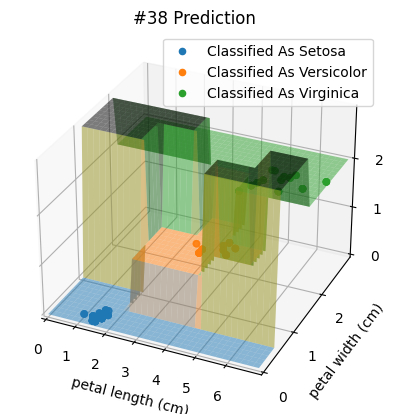

In [4]:
model_from_scratch = DecisionTreeClassifierFromScratch()

model_from_scratch.fit(X_train, y_train)

_ = model_from_scratch.predict(X_test, create_animation=True)

## Compare Implementations

In [5]:
X_train = pd.get_dummies(X_train)
X_test = X_test.drop(['petal length (cm)', 'petal width (cm)'], axis=1)
X_test = pd.get_dummies(X_test)

In [6]:
model_from_scratch = DecisionTreeClassifierFromScratch()

model_from_scratch.fit(X_train, y_train)

y_pred = model_from_scratch.predict(X_test)

print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

Accuracy Score: 0.9736842105263158


In [7]:
model = DecisionTreeClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

Accuracy Score: 0.9736842105263158
